# Imports

In [1]:
using Plots; pythonplot()
using CSV, DataFrames, HDF5, LaTeXStrings
using CurveFit
using Statistics
using Printf
using Roots
include("../src/SW.jl");

    CondaPkg Found dependencies: /Users/wladi/.julia/packages/PythonCall/qTEA1/CondaPkg.toml


    CondaPkg Found dependencies: /Users/wladi/.julia/packages/PythonPlot/KcWMF/CondaPkg.toml


    CondaPkg Found dependencies: /Users/wladi/.julia/packages/PythonPlot/f591M/CondaPkg.toml


    CondaPkg Dependencies already up to date


┌ Warning: `PythonPlot` 1.0.3 is not compatible with this version of `Plots`. The declared compatibility is 1 - 1.0.2.
└ @ Plots /Users/wladi/.julia/packages/Plots/sxUvK/src/backends.jl:55
  Activating

 project at `~/Projects/SW`


In [2]:
function find_inds(nInit, order::Int, V1)
    is = copy(nInit)
    curr_inds = copy(nInit)

    for o in 1:order
        next_inds = []
        for i in curr_inds
            inds, vals = findnz(V1[i,:])
            push!(next_inds, inds)
        end

        curr_inds = filter(x->!(x ∈ is), rmDoubles(vcat(next_inds...)))
        append!(is, curr_inds)
    end

    return rmDoubles(vcat(is...))
end

find_inds (generic function with 1 method)

# Perturbation Theory

## Rayleigh–Schrödinger

### States

In [3]:
function first_order_states(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])
    vals = map(zip(inds2, vals2)) do (k2,v2)
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]
        return v2/DE2
    end
    return sparsevec(inds2, Float64.(vals), length(V[nState,:]), +)
end

function second_order_states(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])
    res_inds1 = Int[]
    res_vals1 = Float64[]
    for (k2, v2) in zip(inds2, vals2)
        nState == k2 && continue
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        for (k3,v3) in zip(inds3, vals3)
            H0[nState,nState] == H0[k3,k3] && continue
            # nState == k3 && continue
            DE3 = H0[nState,nState] - H0[k3,k3]

            push!(res_inds1, k3)
            push!(res_vals1, v2*v3/(DE2*DE3))

        end
    end

    res_inds2 = inds2
    res_vals2 = map(zip(inds2, vals2)) do (k2,v2)
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return v2*V[nState,nState]/(DE2^2)
    end

    res_inds3 = [nState]
    res_vals3 = [mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/(DE2^2)
    end]

    res_inds = vcat(res_inds1, res_inds2, res_inds3)
    res_vals = vcat(res_vals1, -1 .* res_vals2, -0.5 .* res_vals3)

    return sparsevec(res_inds, Float64.(res_vals), length(V[nState,:]), +)
end

function second_order_statesOld(nState, basis_states, H0, V)
    inds2, vals2 = findnz(V[nState,:])
    res_inds1 = Int[]
    res_vals1 = Float64[]
    for (k2,v2) in zip(inds2, vals2)
        nState == k2 && continue
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        for (k3,v3) in zip(inds3, vals3)
            nState == k3 && continue
            DE3 = H0[nState,nState] - H0[k3,k3]

            push!(res_inds1, k3)
            push!(res_vals1, 2*v3/(DE2*DE3))

        end
    end

    res_inds2 = inds2
    res_vals2 = map(zip(inds2, vals2)) do (k2,v2)
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return v2*V[nState,nState]/(DE2^2)
    end

    res_inds3 = [nState]
    res_vals3 = [mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/(DE2^2)
    end]

    vec1 = SparseVector(length(basis_states), res_inds1, res_vals1)
    vec2 = SparseVector(length(basis_states), res_inds2, res_vals2)
    vec3 = SparseVector(length(basis_states), res_inds3, res_vals3)
    return sparse(vec1-vec2-0.5*vec3)
end

function first_order_statesMod(nState, H0, V)
    Vmod = build_V1_mod(H0, V, nState, H0[nState,nState]);
    return Vmod[nState,:]
end

function second_order_statesMod(nState, H0, V)
    Vmod = build_V1_mod(H0, V, nState, H0[nState,nState]);
    return (Vmod^2)[nState,:] - 0.5 * dot(Vmod[nState,:],Vmod[nState,:])
end

second_order_statesMod (generic function with 1 method)

### Energies

In [4]:
function first_order_energy(nState, H0, V)
    return V[nState,nState]
end

function second_order_energy(nState, H0, V)
    inds, vals = findnz(V[nState,:])
    return mapreduce(+, zip(inds, vals)) do (i,v)
        nState == i && return 0
        return abs2(v)/(H0[nState,nState]-H0[i,i])
    end
end

function third_order_energy(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])
    return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        res = mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            # (H0[nState,nState] == H0[k3,k3]) && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            return v2*v3*V[nState,k3]/(DE2*DE3)
        end

        res -= V[nState,nState]*abs(v2)/DE2^2
        return res
    end
end

function fourth_order_energy(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])

    secOrder = second_order_energy(nState, H0, V)

    res1 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            # (H0[nState,nState] == H0[k3,k3]) && return 0
            nState == k3 && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            inds4, vals4 = findnz(V[k3,:])
            return mapreduce(+, zip(inds4, vals4)) do (k4,v4)
                # (H0[nState,nState] == H0[k4,k4]) && return 0
                nState == k4 && return 0
                DE4 = H0[nState,nState] - H0[k4,k4]

                return v2*v3*v4*V[nState,k4]/(DE2*DE3*DE4)
            end
        end
    end

    res2 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/DE2^2
    end

    res3 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            # (H0[nState,nState] == H0[k3,k3]) && return 0
            nState == k3 && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            return v2*v3*V[nState,k3]/(DE2^2*DE3)
        end
    end

    res4 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/DE2^3
    end

    return res1 - secOrder*res2 - 2*V[nState,nState]*res3 + V[nState,nState]^2*res4
end

function sixth_order_energy(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])

    return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        # (H0[nState,nState] == H0[k2,k2]) && return 0
        nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            # (H0[nState,nState] == H0[k3,k3]) && return 0
            nState == k3 && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            inds4, vals4 = findnz(V[k3,:])
            return mapreduce(+, zip(inds4, vals4)) do (k4,v4)
                # (H0[nState,nState] == H0[k4,k4]) && return 0
                nState == k4 && return 0
                DE4 = H0[nState,nState] - H0[k4,k4]

                inds5, vals5 = findnz(V[k4,:])
                return mapreduce(+, zip(inds5, vals5)) do (k5,v5)
                    nState == k5 && return 0
                    # (H0[nState,nState] == H0[k5,k5]) && return 0
                    DE5 = H0[nState,nState] - H0[k5,k5]

                    inds6, vals6 = findnz(V[k5,:])
                    return mapreduce(+, zip(inds6, vals6)) do (k6,v6)
                        nState == k6 && return 0
                        # (H0[nState,nState] == H0[k6,k6]) && return 0
                        DE6 = H0[nState,nState] - H0[k6,k6]

                        return v2*v3*v4*v5*v6*V[nState,k6]/(DE2*DE3*DE4*DE5*DE6)
                    end
                end
            end
        end
    end
end

function eighth_order_energy(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])

    return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        # nState == k2 && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            (H0[nState,nState] == H0[k3,k3]) && return 0
            # nState == k3 && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            inds4, vals4 = findnz(V[k3,:])
            return mapreduce(+, zip(inds4, vals4)) do (k4,v4)
                (H0[nState,nState] == H0[k4,k4]) && return 0
                DE4 = H0[nState,nState] - H0[k4,k4]

                inds5, vals5 = findnz(V[k4,:])
                return mapreduce(+, zip(inds5, vals5)) do (k5,v5)
                    (H0[nState,nState] == H0[k5,k5]) && return 0
                    DE5 = H0[nState,nState] - H0[k5,k5]

                    inds6, vals6 = findnz(V[k5,:])
                    return mapreduce(+, zip(inds6, vals6)) do (k6,v6)
                        (H0[nState,nState] == H0[k6,k6]) && return 0
                        DE6 = H0[nState,nState] - H0[k6,k6]

                        inds7, vals7 = findnz(V[k6,:])
                        return mapreduce(+, zip(inds7, vals7)) do (k7,v7)
                            (H0[nState,nState] == H0[k7,k7]) && return 0
                            DE7 = H0[nState,nState] - H0[k7,k7]

                            inds8, vals8 = findnz(V[k7,:])
                            return mapreduce(+, zip(inds8, vals8)) do (k8,v8)
                                (H0[nState,nState] == H0[k8,k8]) && return 0
                                DE8 = H0[nState,nState] - H0[k8,k8]


                                return v2*v3*v4*v5*v6*v7*v8*V[nState,k8]/(DE2*DE3*DE4*DE5*DE6*DE7*DE8)
                            end
                        end
                    end
                end
            end
        end
    end
end

eighth_order_energy (generic function with 1 method)

In [5]:
function first_order_energyD(nState, H0, V)
    return V[nState,nState]
end

function second_order_energyD(nState, H0, V)
    inds, vals = findnz(V[nState,:])
    return mapreduce(+, zip(inds, vals)) do (i,v)
        (H0[nState,nState] == H0[i,i]) && return 0
        return abs2(v)/(H0[nState,nState]-H0[i,i])
    end
end

function third_order_energyD(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])
    return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        res = mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            (H0[nState,nState] == H0[k3,k3]) && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            return v2*v3*V[nState,k3]/(DE2*DE3)
        end

        res -= V[nState,nState]*abs2(v2)/DE2^2
        return res
    end
end

function fourth_order_energyD(nState, H0, V)
    inds2, vals2 = findnz(V[nState,:])

    secOrder = second_order_energy(nState, H0, V)

    res1 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            (H0[nState,nState] == H0[k3,k3]) && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            inds4, vals4 = findnz(V[k3,:])
            return mapreduce(+, zip(inds4, vals4)) do (k4,v4)
                (H0[nState,nState] == H0[k4,k4]) && return 0
                DE4 = H0[nState,nState] - H0[k4,k4]

                return v2*v3*v4*V[nState,k4]/(DE2*DE3*DE4)
            end
        end
    end

    res2 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/DE2^2
    end

    res3 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        inds3, vals3 = findnz(V[k2,:])
        return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
            (H0[nState,nState] == H0[k3,k3]) && return 0
            DE3 = H0[nState,nState] - H0[k3,k3]

            return v2*v3*V[nState,k3]/(DE2^2*DE3)
        end
    end

    res4 = mapreduce(+, zip(inds2, vals2)) do (k2,v2)
        (H0[nState,nState] == H0[k2,k2]) && return 0
        DE2 = H0[nState,nState] - H0[k2,k2]

        return abs2(v2)/DE2^3
    end

    return res1 - secOrder*res2 - 2*V[nState,nState]*res3 + V[nState,nState]^2*res4
end

fourth_order_energyD (generic function with 1 method)

## Results

### Brillouin-Wigner

In [201]:
L= (4,4)
N = prod(L);
J = -1;
g = -0.5
h = -0.

next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

spin_basisF = vec(collect(Iterators.product(fill([1,0],N)...)));
dw_precalcF = map(spin_basisF) do spin
    return domainWallL(spin, L)
end

### sort basis according to domain wall length ###
sorted_spin_basis = sort(collect(zip(dw_precalcF, spin_basisF)), by = x->x[1])
dw_precalcF  = [d[1] for d in sorted_spin_basis]
spin_basisF  = [d[2] for d in sorted_spin_basis];
imb_precalcF = map(s -> imbalance(s, L), spin_basisF)

spin_basis_tableF = Dict(
    map(enumerate(zip(spin_basisF,dw_precalcF))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
);

### initial state ###
init_spin = vcat(fill(1,Int(N/2)),fill(0,Int(N/2)))
init_idx = first(spin_basis_tableF[Tuple(init_spin)])

init_states_indices = [145,205,251,285,336,370,416,476]

# ### build Hamiltonians ###
H0  = build_H0(spin_basisF, next_neighbours, spin_basis_tableF, (L,J,g,h));
H1F, R1F = build_H1_R1(spin_basisF, spin_basis_tableF, (L,J,g,h));
V = sparse(H1F+R1F);
HF = H0+V;

In [ ]:
ts = [0.0,0.1]
step = 1.1
tmax = 1e10

### logarithmic timesteps ###
while true
    push!(ts, ts[end]*step)
    ts[end] > tmax && break
end

In [ ]:
# gs = [-0.2]
# orderData = map(1:1) do order
order = 0
L= (4,4)
N = prod(L);
J = -1;

valsD, vecsD = eigen(Matrix(V[99:522,99:522]))
transf = sparse(Matrix(1.0I, 2^16, 2^16))
transf[99:522,99:522] = vecsD;

V = transf*V*transf'

init_states_indices = collect(99:522)

is = find_inds(init_states_indices, order, V)
energies_basisRed = map(is) do i
    EInit = H0[i,i] - 0.1

    f(x) = x - (H0[i,i] + BW_second_order_energy(i, H0, V, x)) # + BW_fourth_order_energyMod(i, H0, V, x))
    E = find_zero(f, EInit)
    vec = sparse(sparsevec([i], [1], 2^16) + BW_nth_order_statesMod(1, i, H0, V, E) + BW_nth_order_statesMod(2, i, H0, V, E))# + BW_nth_order_statesMod(3, i, H0, V, E) + BW_nth_order_statesMod(4, i, H0, V, E))
    # vec = sparsevec([i], [1], 2^16) + first_order_states(i, spin_basisF, H0, V) + second_order_states(i, spin_basisF, H0, V)
    return (E, vec/ norm(vec))
end

energiesRed = [d[1] for d in energies_basisRed]
spin_basisRed = [d[2] for d in energies_basisRed]

dw_precalcRed  = [dot(s, H0*s) for s in spin_basisRed]

spin_basis_table = Dict(
    map(enumerate(zip(spin_basisRed,dw_precalcRed))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
);

### initial state ###
init_inds_vals = map(spin_basisRed) do s
    return first(spin_basis_table[s]), s[init_idx] 
end
psi = sparsevec([d[1] for d in init_inds_vals], [d[2] for d in init_inds_vals], length(spin_basisRed));

# ### build Hamiltonian ###
# H  = sparse(map(Iterators.product(spin_basisRed, spin_basisRed)) do (s1,s2)
#     return dot(s1, HF*s2)
# end)

# ### symmetrize
# H = 0.5*(H+Transpose(H))

H = spdiagm(energiesRed)

# @show H
# @show norm(spin_basisRed[1])
# @show [-16 + second_order_energy(i, H0, V) for i in init_states_indices]

println("Starting caluclation of eigenvectors/-values")
vals, vecs = eigen(Matrix(H))

psi = Transpose(vecs) * psi

imb_precalc = map(i -> imb_precalcF[i], is)
data = Any[]

for (t, tf) in zip(ts[1:end-1], ts[2:end])
    dt = tf-t

    psi_prime = vecs*psi

    imb = mapreduce(+, enumerate(psi_prime)) do (i,psi_i)
        α = abs2(psi_i)
        return α * imb_precalc[i]
    end

    dwObs = 8 #real.(dot(psi_prime, H0      * psi_prime))

    append!(data, [[t, imb, dwObs]])

    # Propagate state
    U = exp.(-1im*dt .* vals)
    psi = U .* psi
end

df = DataFrame(t = [real(d[1]) for d in data], imb = [real(d[2]) for d in data], N = [real(d[3]) for d in data])
# return df
# CSV.write("./obs_Eff_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", df)
# end

In [ ]:
energiesRed

In [ ]:
let
    V_red = map(Iterators.product(init_states_indices,init_states_indices)) do (i,j)
        return V[i,j]
    end

    # VDeg = Transpose(transf)*V*transf
end

In [ ]:
gs = [-0.5]
pimbs = map(gs) do g
    L = (4,4)
    J = -1
    h = -0.

    dfE  = CSV.read("../data/obs_ED_n=3_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv",    DataFrame)
    dfEff  = df #CSV.read("../data/obs_Eff_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv",    DataFrame)
    dfS1 = CSV.read("../data/timeEv_dw8states_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", DataFrame)
    dfS2 = CSV.read("../data/timeEv_dw8_10states_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", DataFrame)

    plot(title = "L=($(L[1]),$(L[2])), J=$(J), g=$(g)", xlabel = "time t", ylabel = "imbalance I",
                xlim = (0.1,1e10), xaxis = :log,
                # ylim = (-1,1),
                legend = :bottomleft,
            )

    plot!(dfE[:,"t"], dfE[:,"imb"],   label="full", color=:blue, linewidth = 2)
    plot!(dfEff[:,"t"], dfEff[:,"imb"],   label="eff", linewidth = 3)
    plot!(dfS1[:,"t"], dfS1[:,"imb"], label="DW = 8 states", color=:green, linestyle=:dash)
    plot!(dfS2[:,"t"], dfS2[:,"imb"], label="DW = 8 & 10 states", color=:red, linestyle=:dash)
end

plot(pimbs..., dpi=300, size = (1000,800))

In [ ]:
gs = [-0.2]
pimbs = map(gs) do g
    L = (4,4)
    J = -1
    h = -0.

    dfE  = CSV.read("../data/obs_ED_n=3_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv",    DataFrame)
    dfEff  = df #CSV.read("../data/obs_Eff_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv",    DataFrame)
    dfS1 = CSV.read("../data/timeEv_dw8states_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", DataFrame)
    dfS2 = CSV.read("../data/timeEv_dw8_10states_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", DataFrame)

    plot(title = "L=($(L[1]),$(L[2])), J=$(J), g=$(g)", xlabel = "time t", ylabel = "imbalance I",
                xlim = (0.1,1e10), xaxis = :log,
                # ylim = (-1,1),
                legend = :bottomleft,
            )

    plot!(dfE[:,"t"], dfE[:,"imb"],   label="full", color=:blue, linewidth = 2)
    plot!(dfEff[:,"t"], dfEff[:,"imb"],   label="eff", linewidth = 3)
    plot!(dfS1[:,"t"], dfS1[:,"imb"], label="DW = 8 states", color=:green, linestyle=:dash)
    plot!(dfS2[:,"t"], dfS2[:,"imb"], label="DW = 8 & 10 states", color=:red, linestyle=:dash)
end

plot(pimbs..., dpi=300, size = (1000,800))

In [ ]:
let
    psi_test = dropzeros(sparsevec([d[1] for d in init_inds_vals], [conj(d[2]) for d in init_inds_vals], length(spin_basisRed)))
    psi_test_new = round.(vecs*Transpose(vecs)*psi_test, digits = 3)
    @show psi_test
end

In [ ]:
let
    psi_test = dropzeros(sparsevec([d[1] for d in init_inds_vals], [d[2] for d in init_inds_vals], length(spin_basisRed)))
    psi_test_new = round.(vecs*Transpose(vecs)*psi_test, digits = 3)
    @show psi_test
    # imb = mapreduce(+, enumerate(psi_test)) do (i,psi_i)
    #     α = abs2(psi_i)
    #     return α * imb_precalc[i]
    # end
end
# norm(Transpose(vecs)*psi)

In [ ]:
let
    round.(Transpose(vecs)*vecs, digits = 3)
end

In [ ]:
norm(psi)

In [ ]:
    let
        i = is[10]
        EInit = -12.1

        f(x) = x - (H0[i,i] + BW_second_order_energy(i, H0, V, x))# + BW_fourth_order_energyMod(i, H0, V, x))
        E = find_zero(f, EInit)
        H0[i,i]
        @show E, H0[i,i]
    end

In [ ]:
toSpinMatr(spin_basisF[is[10]])

In [ ]:
# @show Matrix(H)
@show energiesRed[10]
# @show spin_basisRed[10]

In [ ]:
let 
    # nState = 476
    gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
    g = -0.5

    # E = -16.1
    # g = -0.5
    # H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    # V1 = sparse(H1+R1);
    # V = V1

    # inds1, vals1 = findnz(V[nState,:])
    # return mapreduce(+, zip(inds1, vals1)) do (k1,v1)
    #     nState == k1 && return 0
    #     DE1 = E - H0[k1,k1]

    #     inds2, vals2 = findnz(V[k1,:])
    #     return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
    #         nState == k2 && return 0
    #         DE2 = E - H0[k2,k2]

    #         inds3, vals3 = findnz(V[k2,:])
    #         return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
    #             nState == k3 && return 0
    #             DE3 = E - H0[k3,k3]

    #             return v3*v2*v1*V[nState,k3]/(DE1*DE2*DE3)
    #         end
    #     end
    # end

    # data = map(init_states_indices) do nState
    # data = map(gs) do g

    nState = 476
    H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    V1 = sparse(H1+R1);
    V = V1
    EInit = -16.1

    f2Mod(x) = x - (H0[nState,nState] + BW_second_order_energyMod(nState, H0, V, x))
    f4Mod(x) = x - (H0[nState,nState] + BW_second_order_energyMod(nState, H0, V, x) + BW_fourth_order_energyMod(nState, H0, V, x))
    f2(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x))
    f4(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x))
    f6(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x))
    f8(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x) + BW_eighth_order_energy(nState, H0, V, x))

    # inds, vals = findnz(V[nState,:])
    # f(x) = x - 16 + mapreduce(+, zip(inds, vals)) do (i,v)
    #     nState == i && return 0
    #     DE = E-H0[i,i]
    #     return abs2(v)/DE
    # end

    @time res1 = find_zero(f4Mod, EInit) +16
    @time res2 = find_zero(f4, EInit) +16
    @show res1, res2

    #     return find_zero(f2, EInit) +16, find_zero(f4, EInit) +16, find_zero(f6, EInit) +16
    # end
    # @show data


    # p = scatter(abs.(gs),[0.0400, 0.161, 0.364, 0.651, 1.03], label = "data", legend = :topleft, 
    #     title = "scaling of energy difference", xlabel = "g", ylabel = L"\Delta E", markersize=5)

    # scatter!(abs.(gs), [abs(d[1]) for d in data], label = "second order")
    # scatter!(abs.(gs), [abs(d[2]) for d in data], label = "fourth order")
    # scatter!(abs.(gs), [abs(d[3]) for d in data], label = "sixth order")
    # plot(p)
end

In [ ]:
let 
    # nState = 476
    gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
    g = -0.5

    nState = 476
    H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    V1 = sparse(H1+R1);
    V = V1
    EInit = -16.1

    f2Mod(x) = x - (H0[nState,nState] + BW_second_order_energyMod(nState, H0, V, x))
    f4Mod(x) = x - (H0[nState,nState] + BW_second_order_energyMod(nState, H0, V, x) + BW_fourth_order_energyMod(nState, H0, V, x))
    f2(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x))
    f4(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x))
    f6(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x))
    f8(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x) + BW_eighth_order_energy(nState, H0, V, x))


    # inds, vals = findnz(V[nState,:])
    # f(x) = x - 16 + mapreduce(+, zip(inds, vals)) do (i,v)
    #     nState == i && return 0
    #     DE = E-H0[i,i]
    #     return abs2(v)/DE
    # end
    @time res1 = find_zero(f4Mod, EInit) +16
    @time res2 = find_zero(f4, EInit) +16
    @show res1, res2
    #     return find_zero(f2, EInit) +16, find_zero(f4, EInit) +16, find_zero(f6, EInit) +16
    # end
    # @show data


    # p = scatter(abs.(gs),[0.0400, 0.161, 0.364, 0.651, 1.03], label = "data", legend = :topleft, 
    #     title = "scaling of energy difference", xlabel = "g", ylabel = L"\Delta E", markersize=5)

    # scatter!(abs.(gs), [abs(d[1]) for d in data], label = "second order")
    # scatter!(abs.(gs), [abs(d[2]) for d in data], label = "fourth order")
    # scatter!(abs.(gs), [abs(d[3]) for d in data], label = "sixth order")
    # plot(p)
end

calcTime normal = [0.006s, 0.06s, 17s, >72min]
calcTime matrix = [0.27s, 5s, 30s, 6min]

In [ ]:
# nState = 476
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
g = -0.5

# E = -16.1
# g = -0.5
# H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
# V1 = sparse(H1+R1);
# V = V1

# inds1, vals1 = findnz(V[nState,:])
# return mapreduce(+, zip(inds1, vals1)) do (k1,v1)
#     nState == k1 && return 0
#     DE1 = E - H0[k1,k1]

#     inds2, vals2 = findnz(V[k1,:])
#     return mapreduce(+, zip(inds2, vals2)) do (k2,v2)
#         nState == k2 && return 0
#         DE2 = E - H0[k2,k2]

#         inds3, vals3 = findnz(V[k2,:])
#         return mapreduce(+, zip(inds3, vals3)) do (k3,v3)
#             nState == k3 && return 0
#             DE3 = E - H0[k3,k3]

#             return v3*v2*v1*V[nState,k3]/(DE1*DE2*DE3)
#         end
#     end
# end

dataInds = map(init_states_indices) do nState
    g = -0.5
    H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    V1 = sparse(H1+R1);
    V = V1
    EInit = -16.1

    f2(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x))
    f4(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x))
    f6(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x))
    f8(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x) + BW_eighth_order_energy(nState, H0, V, x))

    return find_zero(f2, EInit) +16, find_zero(f4, EInit) +16, find_zero(f6, EInit) +16
end

In [ ]:
dataInds8 = map(init_states_indices) do nState
    g = -0.5
    H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    V1 = sparse(H1+R1);
    V = V1
    EInit = -16.1

    f2(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x))
    f4(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x))
    f6(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x))
    f8(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x) + BW_fourth_order_energy(nState, H0, V, x) + BW_sixth_order_energy(nState, H0, V, x) + BW_eighth_order_energy(nState, H0, V, x))

    return find_zero(f8, EInit) +16
end

In [ ]:
p = plot(legend = :topleft, title = "energy difference")

scatter!([abs(d[1]) for d in dataInds], label = "second order")
scatter!([abs(d[2]) for d in dataInds], label = "fourth order")
scatter!([abs(d[3]) for d in dataInds], label = "sixth order")
plot(p)

In [ ]:
let 
    nState = 476
    g = -0.5

    H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    V1 = sparse(H1+R1);
    V = V1

    f2(x) = x - (H0[nState,nState] + BW_second_order_energy(nState, H0, V, x))
    f4(x) = BW_fourth_order_energy(nState, H0, V, x)
    f6(x) = BW_sixth_order_energy(nState, H0, V, x)
    f8(x) = BW_eighth_order_energy(nState, H0, V, x)

    x = -17:0.1:-15

    data2 = f2.(x)
    data4 = data2 .- f4.(x) 
    data6 = data4 .- f6.(x) 


    plot()
    plot!(x, data2, label = "second order")
    plot!(x, data4, label = "fourth order")
    plot!(x, data6, label = "sixth order")
    # plot!(x, f8.(x), label = "eighth order")
end

### Rayleigh–Schrödinger

#### full run for order 0

In [26]:
ts = [0.0,0.1]
step = 1.1
tmax = 1e10

### logarithmic timesteps ###
while true
    push!(ts, ts[end]*step)
    ts[end] > tmax && break
end

L= (4,4)
N = prod(L);
J = -1;
h = -0.
order = 0

next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

spin_basisF = vec(collect(Iterators.product(fill([1,0],N)...)));
dw_precalcF = map(spin_basisF) do spin
    return domainWallL(spin, L)
end

### sort basis according to domain wall length ###
sorted_spin_basis = sort(collect(zip(dw_precalcF, spin_basisF, 1:length(spin_basisF))), by = x->x[1])
dw_precalcF  = [d[1] for d in sorted_spin_basis]
spin_basisF  = [d[2] for d in sorted_spin_basis];
spin_vectorsF= [sparsevec([d[3]], [1.], length(spin_basisF)) for d in sorted_spin_basis];
imb_precalcF = map(s -> imbalance(s, L), spin_basisF)

spin_basis_tableF = Dict(
    map(enumerate(zip(spin_basisF,dw_precalcF))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
);

### initial state ###
init_spin = vcat(fill(1,Int(N/2)),fill(0,Int(N/2)))
init_idx = first(spin_basis_tableF[Tuple(init_spin)])

init_states_indices = [145,205,251,285,336,370,416,476]

# ### build Hamiltonians ###
H0  = build_H0(spin_basisF, next_neighbours, spin_basis_tableF, (L,J,1,h));
H1F, R1F = build_H1_R1(spin_basisF, spin_basis_tableF, (L,J,1,h));
V = sparse(H1F+R1F);
Imb = spdiagm(imb_precalcF);
interval = 523:2250
valsD, vecsD = eigen(Matrix(V[interval,interval]))
transf = sparse(Matrix(1.0I, 2^16, 2^16))
transf[interval,interval] = vecsD;

V= Transpose(transf)*V*transf;
droptol!(V, 1e-6)

gs = [-0.1,-0.2,-0.3,-0.4,-0.5]

testdataOrder0 = map(gs) do g

    is = find_inds(init_states_indices, order, V)
    energies_basisRed = map(is) do i
        E = (H0[i,i], 0, second_order_energy(i, H0, V))
        vec = (sparsevec([i], [1], 2^16), first_order_states(i, H0, V), second_order_states(i, H0, V))
        return (E, vec)
    end

    energiesRed = map(energies_basisRed) do d 
        mapreduce(+, enumerate(d[1])) do (i,v)
            return g^(i-1)*v
        end
    end

    spin_basisRed = map(energies_basisRed) do d 
        mapreduce(+, enumerate(d[2])) do (i,v)
            return g^(i-1)*v
        end
    end

    dw_precalcRed = map(i -> dw_precalcF[i], is)

    spin_basis_table = Dict(
        map(enumerate(zip(spin_basisRed,dw_precalcRed))) do (i, (spin, dw))
            return (spin, (i,dw))
        end
    );

    ### initial state ###
    init_inds_vals = map(spin_basisRed) do s
        return first(spin_basis_table[s]), s[init_idx] 
    end

    HF = H0+g*V;
    # ### build Hamiltonian ###
    H  = sparse(map(Iterators.product(spin_basisRed, spin_basisRed)) do (s1,s2)
        return dot(s1, HF*s2)
    end)

    ### symmetrize
    H = 0.5*(H+Transpose(H))
    println("Starting caluclation of eigenvectors/-values")
    vals, vecs = eigen(Matrix(H))

    psi = sparsevec([d[1] for d in init_inds_vals], [d[2] for d in init_inds_vals], length(spin_basisRed));
    psi = Transpose(vecs) * psi

    imb_precalc = map(i -> imb_precalcF[i], is)

    data = Any[]

    for (t, tf) in zip(ts[1:end-1], ts[2:end])
        dt = tf-t

        psi_prime = vecs*psi

        imb = mapreduce(+, enumerate(psi_prime)) do (i,psi_i)
            α = abs2(psi_i)
            return α * imb_precalc[i]
        end

        dwObs = mapreduce(+, enumerate(psi_prime)) do (i,psi_i)
            α = abs2(psi_i)
            return α * dw_precalcRed[i]
        end

        append!(data, [[t, imb, dwObs]])

        # Propagate state
        U = exp.(-1im*dt .* vals)
        psi = U .* psi
    end

    df = DataFrame(t = [real(d[1]) for d in data], imb = [real(d[2]) for d in data], N = [real(d[3]) for d in data])
    # CSV.write("../data/obs_Eff_order=$(order)_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", df)
    return df
end

Starting caluclation of eigenvectors/-values


Starting caluclation of eigenvectors/-values


Starting caluclation of eigenvectors/-values


Starting caluclation of eigenvectors/-values


Starting caluclation of eigenvectors/-values


5-element Vector{DataFrame}:
 267×3 DataFrame
 Row │ t          imb       N       
     │ Float64    Float64   Float64 
─────┼──────────────────────────────
   1 │ 0.0        0.990025   7.9202
   2 │ 0.1        0.990025   7.9202
   3 │ 0.11       0.990025   7.9202
   4 │ 0.121      0.990025   7.9202
   5 │ 0.1331     0.990025   7.9202
   6 │ 0.14641    0.990025   7.9202
   7 │ 0.161051   0.990025   7.9202
   8 │ 0.177156   0.990025   7.9202
  ⋮  │     ⋮         ⋮         ⋮
 261 │ 5.25661e9  0.985766   7.9202
 262 │ 5.78227e9  0.984923   7.9202
 263 │ 6.36049e9  0.983927   7.9202
 264 │ 6.99654e9  0.982754   7.9202
 265 │ 7.6962e9   0.981382   7.9202
 266 │ 8.46582e9  0.97979    7.9202
 267 │ 9.3124e9   0.97796    7.9202
                    252 rows omitted
 267×3 DataFrame
 Row │ t          imb       N       
     │ Float64    Float64   Float64 
─────┼──────────────────────────────
   1 │ 0.0        0.9604     7.6832
   2 │ 0.1        0.9604     7.6832
   3 │ 0.11       0.9604     7.68

In [22]:
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
testPsi = map(gs) do g
    ts = [0.0,0.1]
    step = 1.1
    tmax = 1e10

    ### logarithmic timesteps ###
    while true
        push!(ts, ts[end]*step)
        ts[end] > tmax && break
    end

    L= (4,4)
    N = prod(L);
    J = -1;
    h = -0.
    order = 0

    next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

    spin_basisF = vec(collect(Iterators.product(fill([1,0],N)...)));
    dw_precalcF = map(spin_basisF) do spin
        return domainWallL(spin, L)
    end

    ### sort basis according to domain wall length ###
    sorted_spin_basis = sort(collect(zip(dw_precalcF, spin_basisF, 1:length(spin_basisF))), by = x->x[1])
    dw_precalcF  = [d[1] for d in sorted_spin_basis]
    spin_basisF  = [d[2] for d in sorted_spin_basis];
    spin_vectorsF= [sparsevec([d[3]], [1.], length(spin_basisF)) for d in sorted_spin_basis];
    imb_precalcF = map(s -> imbalance(s, L), spin_basisF)

    spin_basis_tableF = Dict(
        map(enumerate(zip(spin_basisF,dw_precalcF))) do (i, (spin, dw))
            return (spin, (i,dw))
        end
    );

    ### initial state ###
    init_spin = vcat(fill(1,Int(N/2)),fill(0,Int(N/2)))
    init_idx = first(spin_basis_tableF[Tuple(init_spin)])

    init_states_indices = [145,205,251,285,336,370,416,476]

    # ### build Hamiltonians ###
    H0  = build_H0(spin_basisF, next_neighbours, spin_basis_tableF, (L,J,g,h));
    H1F, R1F = build_H1_R1(spin_basisF, spin_basis_tableF, (L,J,g,h));
    V = sparse(H1F+R1F);
    HF = H0+V;
    Imb = spdiagm(imb_precalcF);
    interval = 523:2250
    valsD, vecsD = eigen(Matrix(V[interval,interval]))
    transf = sparse(Matrix(1.0I, 2^16, 2^16))
    transf[interval,interval] = vecsD;

    V= Transpose(transf)*V*transf;
    droptol!(V, 1e-6)

    is = find_inds(init_states_indices, order, V)
    energies_basisRed = map(is) do i
        E = H0[i,i] + second_order_energy(i, H0, V)
        vec = sparsevec([i], [1], 2^16) + first_order_states(i, H0, V) + second_order_states(i, H0, V)
        return (E, vec / norm(vec))
    end

    energiesRed   = [d[1] for d in energies_basisRed]
    spin_basisRed = [d[2] for d in energies_basisRed]
    dw_precalcRed = map(i -> dw_precalcF[i], is)

    spin_basis_table = Dict(
        map(enumerate(zip(spin_basisRed,dw_precalcRed))) do (i, (spin, dw))
            return (spin, (i,dw))
        end
    );

    ### initial state ###
    init_inds_vals = map(spin_basisRed) do s
        return first(spin_basis_table[s]), s[init_idx] 
    end

    psi = sparsevec([d[1] for d in init_inds_vals], [d[2] for d in init_inds_vals], length(spin_basisRed));

    return psi
end

5-element Vector{SparseVector{Float64, Int64}}:
   [1]  =  0.0
  [2]  =  0.0
  [3]  =  0.0
  [4]  =  0.0
  [5]  =  0.0
  [6]  =  0.0
  [7]  =  0.0
  [8]  =  0.994951
   [1]  =  0.0
  [2]  =  0.0
  [3]  =  0.0
  [4]  =  0.0
  [5]  =  0.0
  [6]  =  0.0
  [7]  =  0.0
  [8]  =  0.979231
   [1]  =  0.0
  [2]  =  0.0
  [3]  =  0.0
  [4]  =  0.0
  [5]  =  0.0
  [6]  =  0.0
  [7]  =  0.0
  [8]  =  0.951222
   [1]  =  0.0
  [2]  =  0.0
  [3]  =  0.0
  [4]  =  0.0
  [5]  =  0.0
  [6]  =  0.0
  [7]  =  0.0
  [8]  =  0.908642
   [1]  =  0.0
  [2]  =  0.0
  [3]  =  0.0
  [4]  =  0.0
  [5]  =  0.0
  [6]  =  0.0
  [7]  =  0.0
  [8]  =  0.849308

In [25]:
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
testH = map(gs) do g
    ts = [0.0,0.1]
    step = 1.1
    tmax = 1e10

    ### logarithmic timesteps ###
    while true
        push!(ts, ts[end]*step)
        ts[end] > tmax && break
    end

    L= (4,4)
    N = prod(L);
    J = -1;
    h = -0.
    order = 0

    next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

    spin_basisF = vec(collect(Iterators.product(fill([1,0],N)...)));
    dw_precalcF = map(spin_basisF) do spin
        return domainWallL(spin, L)
    end

    ### sort basis according to domain wall length ###
    sorted_spin_basis = sort(collect(zip(dw_precalcF, spin_basisF, 1:length(spin_basisF))), by = x->x[1])
    dw_precalcF  = [d[1] for d in sorted_spin_basis]
    spin_basisF  = [d[2] for d in sorted_spin_basis];
    spin_vectorsF= [sparsevec([d[3]], [1.], length(spin_basisF)) for d in sorted_spin_basis];
    imb_precalcF = map(s -> imbalance(s, L), spin_basisF)

    spin_basis_tableF = Dict(
        map(enumerate(zip(spin_basisF,dw_precalcF))) do (i, (spin, dw))
            return (spin, (i,dw))
        end
    );

    ### initial state ###
    init_spin = vcat(fill(1,Int(N/2)),fill(0,Int(N/2)))
    init_idx = first(spin_basis_tableF[Tuple(init_spin)])

    init_states_indices = [145,205,251,285,336,370,416,476]

    # ### build Hamiltonians ###
    H0  = build_H0(spin_basisF, next_neighbours, spin_basis_tableF, (L,J,g,h));
    H1F, R1F = build_H1_R1(spin_basisF, spin_basis_tableF, (L,J,g,h));
    V = sparse(H1F+R1F);
    HF = H0+V;
    Imb = spdiagm(imb_precalcF);
    interval = 523:2250
    valsD, vecsD = eigen(Matrix(V[interval,interval]))
    transf = sparse(Matrix(1.0I, 2^16, 2^16))
    transf[interval,interval] = vecsD;

    V= Transpose(transf)*V*transf;
    droptol!(V, 1e-6)

    is = find_inds(init_states_indices, order, V)
    energies_basisRed = map(is) do i
        E = H0[i,i] + second_order_energy(i, H0, V)
        vec = sparsevec([i], [1], 2^16) + first_order_states(i, H0, V) + second_order_states(i, H0, V)
        return (E, vec / norm(vec))
    end

    energiesRed   = [d[1] for d in energies_basisRed]
    spin_basisRed = [d[2] for d in energies_basisRed]
    dw_precalcRed = map(i -> dw_precalcF[i], is)

    spin_basis_table = Dict(
        map(enumerate(zip(spin_basisRed,dw_precalcRed))) do (i, (spin, dw))
            return (spin, (i,dw))
        end
    );

    ### initial state ###
    init_inds_vals = map(spin_basisRed) do s
        return first(spin_basis_table[s]), s[init_idx] 
    end

    psi = sparsevec([d[1] for d in init_inds_vals], [d[2] for d in init_inds_vals], length(spin_basisRed));
    # ### build Hamiltonian ###
    H  = sparse(map(Iterators.product(spin_basisRed, spin_basisRed)) do (s1,s2)
        return dot(s1, HF*s2)
    end)
    return H
end

5-element Vector{SparseMatrixCSC{Float64, Int64}}:
 sparse([1, 2, 3, 4, 5, 6, 7, 8, 1, 2  …  7, 8, 1, 2, 3, 4, 5, 6, 7, 8], [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8], [-15.963809117907948, 0.00041607494749338394, 0.002622004773947064, 0.001740736238862037, 0.00029983421030475464, -0.001589929602018371, -0.0015160616954385793, -0.0002945712460691536, 0.000416074947493379, -15.959341803224676  …  -15.959762106110228, 2.214519541786187e-5, -0.00029457124606914996, 0.00019015096033105888, -0.0008628215439320925, -0.00013707554108623301, -2.901345514792554e-5, 0.001082776066512901, 2.2145195417860834e-5, -15.965686898682703], 8, 8)
 sparse([1, 2, 3, 4, 5, 6, 7, 8, 1, 2  …  7, 8, 1, 2, 3, 4, 5, 6, 7, 8], [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,

In [24]:
@show dropzeros.(testPsi)

dropzeros.(testPsi) = SparseVector{Float64, Int64}[  [8]  =  0.994951,   [8]  =  0.979231,   [8]  =  0.951222,   [8]  =  0.908642,   [8]  =  0.849308]


5-element Vector{SparseVector{Float64, Int64}}:
   [8]  =  0.994951
   [8]  =  0.979231
   [8]  =  0.951222
   [8]  =  0.908642
   [8]  =  0.849308

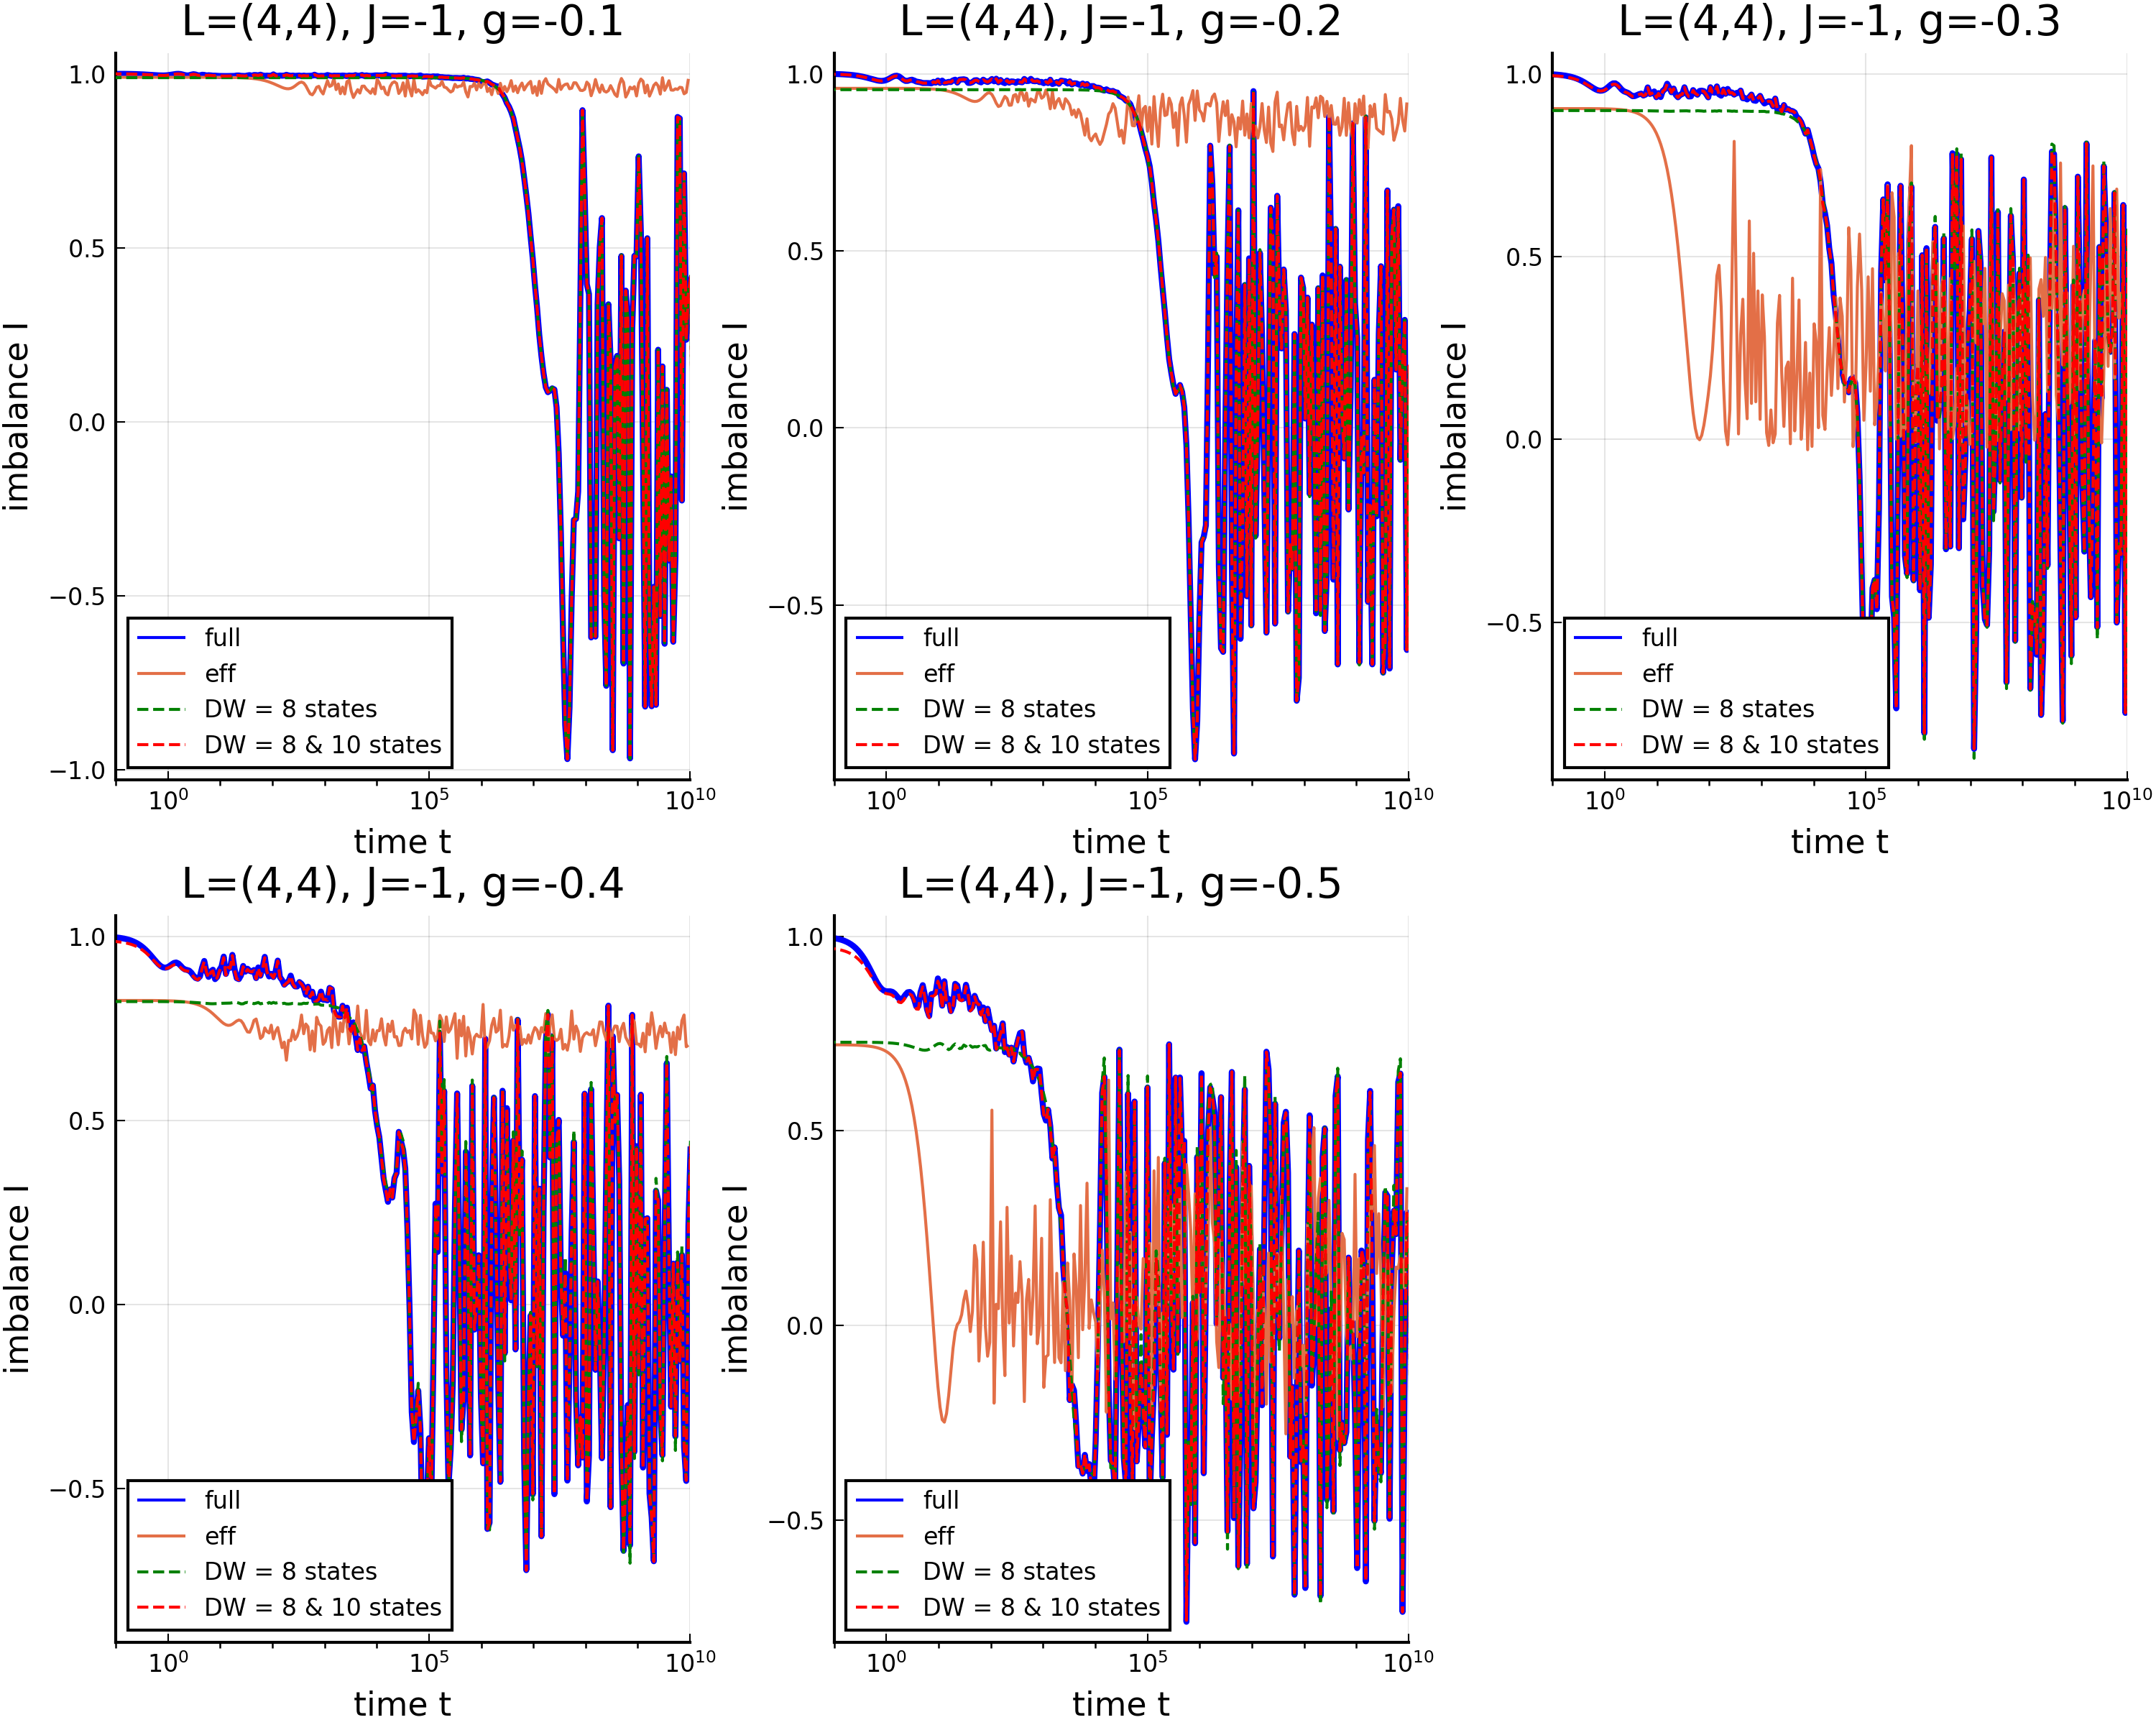

In [53]:
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
pimbs = map(enumerate(gs)) do (i,g)
    L = (4,4)
    J = -1
    h = -0.

    dfE  = CSV.read("../data/obs_ED_n=3_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv",    DataFrame)
    dfEff  = dataOrder0[i] #CSV.read("../data/obs_Eff_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv",    DataFrame)
    dfEff2  = testdataOrder0[i]
    dfS1 = CSV.read("../data/timeEv_dw8states_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", DataFrame)
    dfS2 = CSV.read("../data/timeEv_dw8_10states_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", DataFrame)

    plot(title = "L=($(L[1]),$(L[2])), J=$(J), g=$(g)", xlabel = "time t", ylabel = "imbalance I",
                xlim = (0.1,1e10), xaxis = :log,
                # ylim = (-1,1),
                legend = :bottomleft,
            )

    plot!(dfE[:,"t"], dfE[:,"imb"],   label="full", color=:blue, linewidth = 2)
    plot!(dfEff[:,"t"], dfEff[:,"imb"],   label="eff", linewidth = 1)
    # plot!(dfEff2[:,"t"], dfEff2[:,"imb"],   label="eff2", linewidth = 1, linestyle=:dash)
    plot!(dfS1[:,"t"], dfS1[:,"imb"], label="DW = 8 states", color=:green, linestyle=:dash)
    plot!(dfS2[:,"t"], dfS2[:,"imb"], label="DW = 8 & 10 states", color=:red, linestyle=:dash)
end

plot(pimbs..., dpi=300, size = (1000,800))

#### individual runs

In [29]:
ts = [0.0,0.1]
step = 1.1
tmax = 1e10

### logarithmic timesteps ###
while true
    push!(ts, ts[end]*step)
    ts[end] > tmax && break
end

In [30]:
L= (4,4)
N = prod(L);
J = -1;
g = -0.3
h = -0.

next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

spin_basisF = vec(collect(Iterators.product(fill([1,0],N)...)));
dw_precalcF = map(spin_basisF) do spin
    return domainWallL(spin, L)
end

### sort basis according to domain wall length ###
sorted_spin_basis = sort(collect(zip(dw_precalcF, spin_basisF, 1:length(spin_basisF))), by = x->x[1])
dw_precalcF  = [d[1] for d in sorted_spin_basis]
spin_basisF  = [d[2] for d in sorted_spin_basis];
spin_vectorsF= [sparsevec([d[3]], [1.], length(spin_basisF)) for d in sorted_spin_basis];
imb_precalcF = map(s -> imbalance(s, L), spin_basisF)

spin_basis_tableF = Dict(
    map(enumerate(zip(spin_basisF,dw_precalcF))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
);

### initial state ###
init_spin = vcat(fill(1,Int(N/2)),fill(0,Int(N/2)))
init_idx = first(spin_basis_tableF[Tuple(init_spin)])

init_states_indices = [145,205,251,285,336,370,416,476]

# ### build Hamiltonians ###
H0  = build_H0(spin_basisF, next_neighbours, spin_basis_tableF, (L,J,g,h));
H1F, R1F = build_H1_R1(spin_basisF, spin_basis_tableF, (L,J,g,h));
V = sparse(H1F+R1F);
HF = H0+V;
Imb = spdiagm(imb_precalcF);

dw-8 sector : 99 - 522
dw-10 sector : 523 - 2250

In [31]:
# gs = [-0.2]
# orderData = map(1:1) do order
order = 1
L= (4,4)
N = prod(L);
J = -1;

interval = 523:2250
valsD, vecsD = eigen(Matrix(V[interval,interval]))
transf = sparse(Matrix(1.0I, 2^16, 2^16))
transf[interval,interval] = vecsD;

V= Transpose(transf)*V*transf;
droptol!(V, 1e-6)

for i in interval
    spin_vectorsF[i] = Transpose(transf)*spin_vectorsF[i]
end

In [54]:
is = find_inds(init_states_indices, order, V)
energies_basisRed = map(is) do i
    E = H0[i,i] + second_order_energy(i, H0, V)
    vec = sparsevec([i], [1], 2^16) + first_order_states(i, H0, V) + second_order_states(i, H0, V)

    # EInit = H0[i,i] - 0.1

    # f(x) = x - (H0[i,i] + BW_first_order_energy(i, H0, V, x) + BW_second_order_energy(i, H0, V, x)) # + BW_fourth_order_energyMod(i, H0, V, x))
    # E = find_zero(f, EInit)
    # vec = sparse(sparsevec([i], [1], 2^16) + BW_nth_order_statesMod(1, i, H0, V, E) + BW_nth_order_statesMod(2, i, H0, V, E))# + BW_nth_order_statesMod(3, i, H0, V, E) + BW_nth_order_statesMod(4, i, H0, V, E))
    # vec = sparsevec([i], [1], 2^16) + first_order_states(i, spin_basisF, H0, V) + second_order_states(i, spin_basisF, H0, V)
    return (E, vec)
end

energiesRed   = [d[1] for d in energies_basisRed]
spin_basisRed = [d[2] for d in energies_basisRed]

dw_precalcRed = [dot(s, H0*s) for s in spin_basisRed]

spin_basis_table = Dict(
    map(enumerate(zip(spin_basisRed,dw_precalcRed))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
);

### initial state ###
init_inds_vals = map(spin_basisRed) do s
    return first(spin_basis_table[s]), s[init_idx] 
end


104-element Vector{Tuple{Int64, Float64}}:
 (1, 0.0)
 (2, 0.0)
 (3, 0.0)
 (4, 0.0)
 (5, 0.0)
 (6, 0.0)
 (7, 0.0)
 (8, 0.955)
 (9, 0.0)
 (10, -0.0021176462141257717)
 ⋮
 (96, 0.0)
 (97, -0.013594083586665683)
 (98, -0.0054372591165446765)
 (99, 0.08856653396382608)
 (100, -0.10939431557672515)
 (101, -0.10236560321498067)
 (102, 0.08954887026581775)
 (103, -0.0789612657223232)
 (104, -0.044441021694059495)

In [57]:
# ### build Hamiltonian ###
H  = sparse(map(Iterators.product(spin_basisRed, spin_basisRed)) do (s1,s2)
    return dot(s1, HF*s2)
end)

### symmetrize
H = 0.5*(H+Transpose(H))

104×104 SparseMatrixCSC{Float64, Int64} with 10766 stored entries:
⎡⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣛⣛⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣛⣛⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣭⣭⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎣⣿⣿⣿⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎦

In [60]:
@show Matrix(H)

Matrix(H) = [-15.724811799085092 -0.005745462390937932 0.0038313432127689328 0.0007188766275176271 -0.006340711057362839 0.006094487332178333 -0.011375315715930139 0.004600703312407672 -0.3089943900128134 0.004196751548480535 0.12185787992804861 0.09303672508746083 0.024409864820058212 0.11033637227563489 0.03515832544587005 0.03309838275708428 -0.08205812253015829 0.031338918457278625 -0.021570875017326505 -0.0992842570418405 -0.006859181900867444 -0.013152417771036267 -0.1615658648819423 0.37115446402810337 0.00027614357892537125 -0.00015046285177586433 -0.0009453312433950944 0.3696938153890318 0.0006978129229648384 -0.06408492605111804 -0.2943236151857534 1.7685694534540107e-5 -0.00046601920212590735 0.0001777817617503317 -0.0002778680239466317 -0.0007038610846569647 8.819958418776911e-5 -0.0005186169300146219 -0.36140670021884447 0.36190986024515803 -0.03681445573020864 0.009235800731063067 -0.005171472634113871 0.003358625259448798 0.037619765357583976 -0.007802457175421654 -0.015

599181043 -12.029582440468976 0.11597858921496831 -0.08020149481463296 0.051501601115419196 -0.00894965327925702 -0.07729789345258961 0.027502052947052977 0.0379190150648801 0.01300252684018684 -0.008030740609131186 -0.03362849078991231 0.07999458816399854 0.08514550461863454 -0.014457291749907255 -0.19048235112234208 0.07772350995047492 0.06347987052204912 -0.035499143813412036 -0.03343530696472294 0.006550131676411901 0.10120793735519149 0.014908517742933464 0.02679790156889033 0.06640946371669303 -0.027309925597177258 0.15935809182053662 0.0057728785872741325 0.02434027220556994 0.0877277790536965 0.01950751045402756 -0.059310187699648964 -0.08170824617071845 -0.0552735765936218 0.06277045648660712 -0.02796593375290633 -0.058807557170222555 -0.0033327727492711325 -0.05365081899956969 0.1354003253193236 -0.09141515810040218 0.0326236853181287 -0.0008241289330344158 0.18585791435027182 0.18000830019774788 0.11036887585693347 0.003142128154704912 0.036776539485122134 0.1155254843886969

6812669552214 0.04061588306681582 -0.010395592570391403 0.021543861195241328 0.006780576628981772 -0.0027147070027762742 -0.27751915952349065 0.009689621125110305 -11.731011174697645 0.021419715291225598 0.01721636166015074 0.0005251115610246126 0.005992982350352149 0.04062038665006806 -0.017467544084831747 -0.0016938347328407867 0.016952250359861417 -0.01043926046307309 -0.018424736638419384 0.007192898106273101 0.023985863493984315 -0.02992201247797971; 0.016574131954715965 -0.07064941592752 0.041828560633948 -0.051717473635068775 -0.012120561128123687 0.016464157289241284 0.007922794181994444 0.048851197318146015 0.00484496191608246 0.0767999631212461 -0.011696299755769989 -0.0254009404870628 0.044929626055308494 -0.02678996015395607 0.017951578818180804 0.04987172248623628 -0.027838558690804992 0.08951733066791906 -0.04083865267047777 0.010139353459370563 -0.040526706868479104 -0.015098652271469193 0.05797945775833522 -0.03298453334570005 0.07906323975094572 -0.01351622308464704 0.

104×104 Matrix{Float64}:
 -15.7248        -0.00574546     0.00383134   …    0.000186558   -0.00199378
  -0.00574546   -15.7324        -0.0195162        -0.000654565    0.00736167
   0.00383134    -0.0195162    -15.7233           -0.000759011    0.00861272
   0.000718877    0.00143872    -0.0210513        -0.00130149    -0.00770842
  -0.00634071    -0.00155229     0.00877882       -0.000282699   -0.00567947
   0.00609449    -0.0171672      0.00329557   …   -0.000230768    0.0132989
  -0.0113753      0.00211235    -0.0038694        -0.000635726    0.016499
   0.0046007     -0.00163049     0.0119336        -0.0427934      0.118522
  -0.308994      -0.00493373    -0.00373646        0.0            0.0
   0.00419675     0.266325       0.0437942        -0.0122769     -0.00497494
   ⋮                                          ⋱                 
   0.124817       0.0020593      0.000469502  …    0.0115056      0.000170445
   0.0103201     -0.085508      -0.0373008        -0.0355886     -0.286101

In [58]:
# @show diag(H), energiesRed
# @show norm.(spin_basisRed)
# @show norm(spin_basisRed[1])
# @show [-16 + second_order_energy(i, H0, V) for i in init_states_indices]

println("Starting caluclation of eigenvectors/-values")
vals, vecs = eigen(Matrix(H))

psi = sparsevec([d[1] for d in init_inds_vals], [d[2] for d in init_inds_vals], length(spin_basisRed));
psi = psi
psi = Transpose(vecs) * psi

imb_precalc = map(i -> imb_precalcF[i], is)
data = Any[]

for (t, tf) in zip(ts[1:end-1], ts[2:end])
    dt = tf-t

    psi_prime = vecs*psi

    imb = mapreduce(+, enumerate(psi_prime)) do (i,psi_i)
        α = abs2(psi_i)
        return α * imb_precalc[i]
    end

    dwObs = mapreduce(+, enumerate(psi_prime)) do (i,psi_i)
        α = abs2(psi_i)
        return α * dw_precalcRed[i]
    end

    append!(data, [[t, imb, dwObs]])

    # Propagate state
    U = exp.(-1im*dt .* vals)
    psi = U .* psi
end

df = DataFrame(t = [real(d[1]) for d in data], imb = [real(d[2]) for d in data], N = [real(d[3]) for d in data])
# return df
CSV.write("./obs_8_10_eff_order=1_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", df)
# end

Starting caluclation of eigenvectors/-values


"./obs_8_10_eff_order=1_L=(4_4)_J=-1_g=-0.3_h=-0.0.csv"

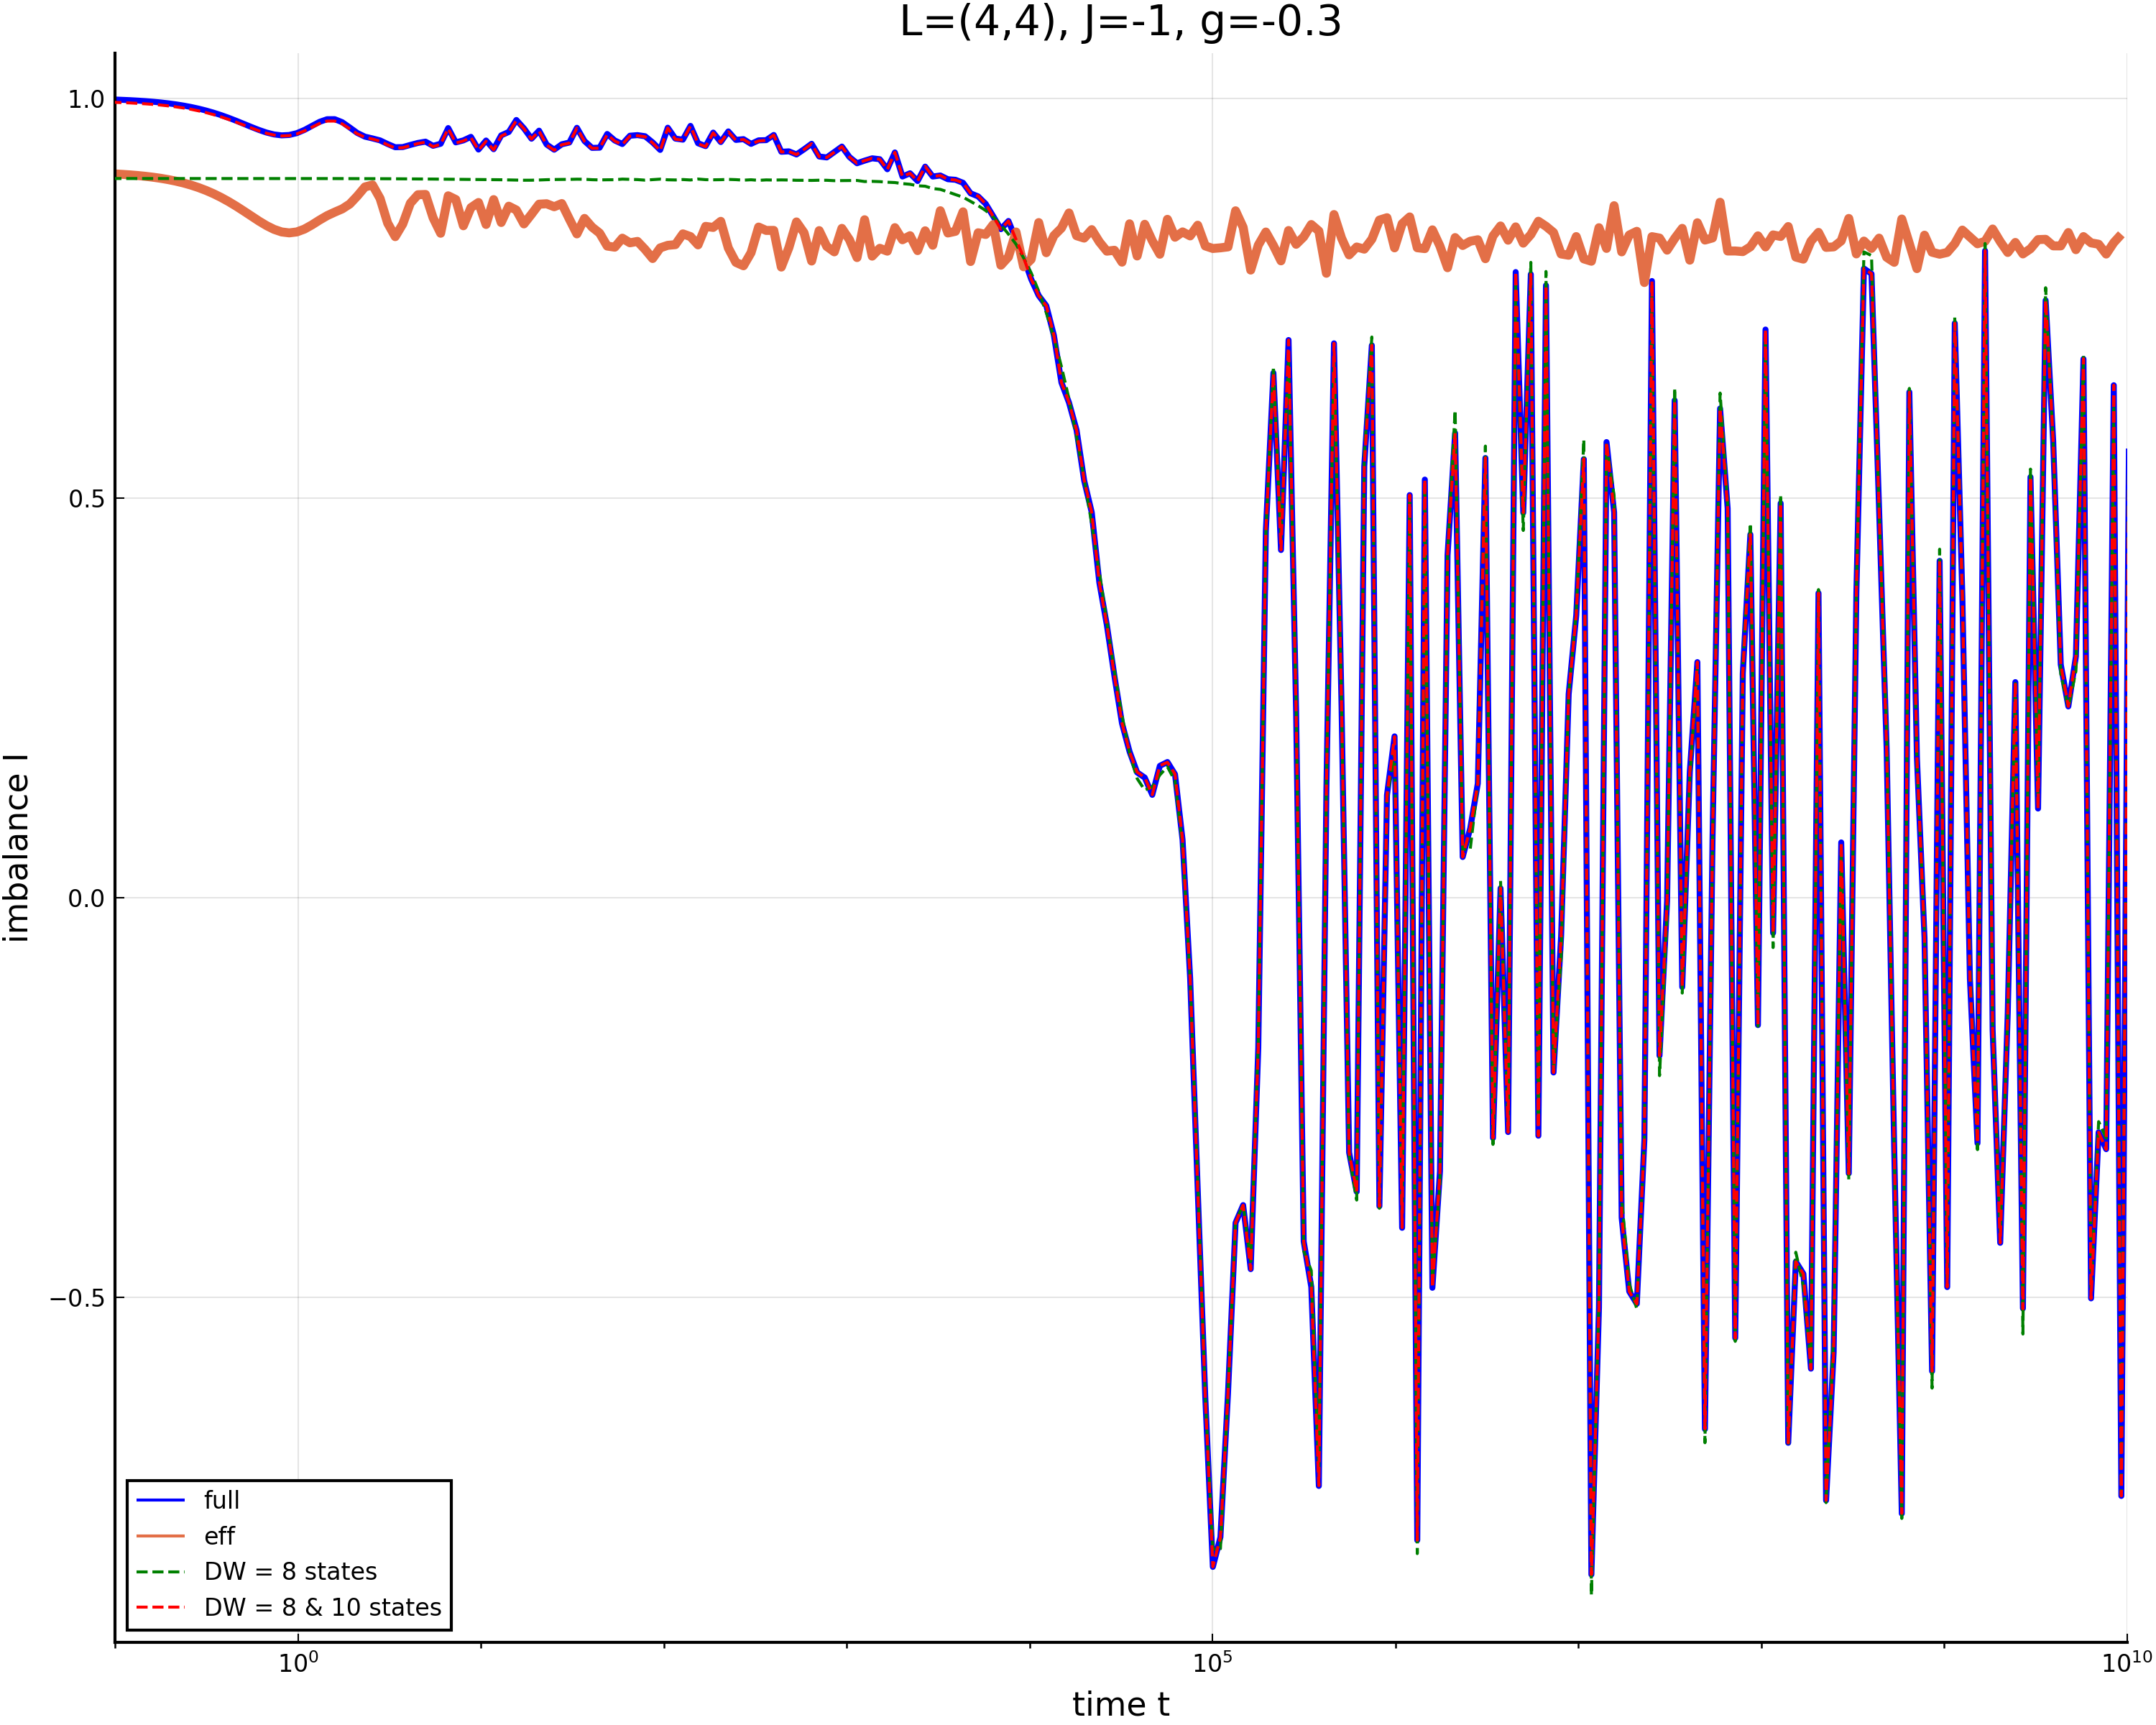

In [59]:
gs = [-0.3]
pimbs = map(gs) do g
    L = (4,4)
    J = -1
    h = -0.

    dfE  = CSV.read("../data/obs_ED_n=3_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv",    DataFrame)
    dfEff  = df #CSV.read("../data/obs_Eff_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv",    DataFrame)
    dfS1 = CSV.read("../data/timeEv_dw8states_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", DataFrame)
    dfS2 = CSV.read("../data/timeEv_dw8_10states_L=($(L[1])_$(L[2]))_J=$(J)_g=$(g)_h=$(h).csv", DataFrame)

    plot(title = "L=($(L[1]),$(L[2])), J=$(J), g=$(g)", xlabel = "time t", ylabel = "imbalance I",
                xlim = (0.1,1e10), xaxis = :log,
                # ylim = (-1,1),
                legend = :bottomleft,
            )

    plot!(dfE[:,"t"], dfE[:,"imb"],   label="full", color=:blue, linewidth = 2)
    plot!(dfEff[:,"t"], dfEff[:,"imb"],   label="eff", linewidth = 3)
    plot!(dfS1[:,"t"], dfS1[:,"imb"], label="DW = 8 states", color=:green, linestyle=:dash)
    plot!(dfS2[:,"t"], dfS2[:,"imb"], label="DW = 8 & 10 states", color=:red, linestyle=:dash)
end

plot(pimbs..., dpi=300, size = (1000,800))

In [ ]:
# is = find_inds(init_states_indices, order, V)
energies_basisRed = map(523) do i
    # E = H0[i,i] + first_order_energy(i, H0, V)# + second_order_energy(i, H0, V)
    # vec = (spin_vectorsF[i], first_order_states(i, H0, V))#, second_order_states(i, H0, V))

    EInit = H0[i,i] - 0.1

    f(x) = x - (H0[i,i] + BW_first_order_energy(i, H0, V, x) + BW_second_order_energy(i, H0, V, x)) # + BW_fourth_order_energyMod(i, H0, V, x))
    E = find_zero(f, EInit)
    vec = sparse(sparsevec([i], [1], 2^16) + BW_nth_order_statesMod(1, i, H0, V, E) + BW_nth_order_statesMod(2, i, H0, V, E))# + BW_nth_order_statesMod(3, i, H0, V, E) + BW_nth_order_statesMod(4, i, H0, V, E))

    # vec = spin_vectorsF[i] + first_order_states(i, H0, V) + second_order_states(i, H0, V)
    return (E, vec / norm(vec))
end

In [51]:
# is = find_inds(init_states_indices, order, V)
energies_basisRed = map(523) do i
    E = H0[i,i] + first_order_energy(i, H0, V) + second_order_energy(i, H0, V)
    vec = (sparsevec([i], [1], 2^16), first_order_states(i, H0, V), second_order_states(i, H0, V)) # + spin_vectorsF[i]
    return (E, vec, sum(vec)/ norm(sum(vec)))
end

(-13.530710940393151, (  [523]  =  1,   [35   ]  =  0.00241496
  [36   ]  =  0.00241496
  [37   ]  =  0.00241496
  [38   ]  =  0.00241496
  [39   ]  =  0.00241496
  [40   ]  =  0.00241496
  [41   ]  =  0.00241496
           ⋮
  [15799]  =  -0.00318691
  [15800]  =  -0.00469894
  [15805]  =  -0.00469894
  [15806]  =  -0.00469894
  [15807]  =  -0.00612854
  [15808]  =  -0.00469894
  [15809]  =  -0.00612854
  [15810]  =  -0.00415649,   [3    ]  =  -0.000905611
  [4    ]  =  -0.000905611
  [5    ]  =  -0.000905611
  [6    ]  =  -0.000905611
  [7    ]  =  -0.000905611
  [8    ]  =  -0.000905611
  [9    ]  =  -0.000905611
           ⋮
  [51580]  =  -4.52805e-5
  [51587]  =  -0.000119509
  [51592]  =  -4.52805e-5
  [51595]  =  -0.000100146
  [51598]  =  -0.000100146
  [51603]  =  -0.000119509
  [51607]  =  -0.00017621
  [51608]  =  -0.00017621),   [3    ]  =  -0.000902115
  [4    ]  =  -0.000902115
  [5    ]  =  -0.000902115
  [6    ]  =  -0.000902115
  [7    ]  =  -0.000902115
  [8    ]  =  

In [ ]:
let 
    ## 523
    Hnew = H0+V;
    @show dot(energies_basisRed[3], Hnew*energies_basisRed[3])
end

In [ ]:
norm(energies_basisRed[2])

In [ ]:
let 
    ## 1023
    Hnew = H0+V;
    @show dot(energies_basisRed[2], Hnew*energies_basisRed[2])
end

In [ ]:
let 
    ## 523
    Hnew = H0+V;
    @show dot(energies_basisRed[2], Hnew*energies_basisRed[2])
end

In [ ]:
filter(x->isnan(x), sum(energies_basisRed[2]))

In [ ]:
H0[523,523]

In [ ]:
Matrix(H)

#### non-degenerate

In [ ]:
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
orderData = map(gs) do g
    L= (4,4)
    N = prod(L);
    J = -1;
    #g = -0.1
    h = -0.

    next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

    spin_basis = vec(collect(Iterators.product(fill([1,0],N)...)));
    dw_precalc = map(spin_basis) do spin
        return domainWallL(spin, L)
    end

    ### sort basis according to domain wall length ###
    sorted_spin_basis = sort(collect(zip(dw_precalc, spin_basis)), by = x->x[1])
    dw_precalc  = [d[1] for d in sorted_spin_basis]
    spin_basis  = [d[2] for d in sorted_spin_basis];

    spin_basis_table = Dict(
        map(enumerate(zip(spin_basis,dw_precalc))) do (i, (spin, dw))
            return (spin, (i,dw))
        end
    );

    domainWall_table = Dict(
        map(enumerate(dw_precalc)) do (i,  dw)
            return (i, dw)
        end
    );

    ### initial state ###
    init_spin = vcat(fill(1,Int(N/2)),fill(0,Int(N/2)))
    init_idx = first(spin_basis_table[Tuple(init_spin)])

    init_states_indices = [145,205,251,285,336,370,416,476]


    # psi=zeros(length(spin_basis))
    # psi[init_idx]=1
    # psi = sparse(psi)

    # ### build Hamiltonians ###
    H0  = build_H0(spin_basis, next_neighbours, spin_basis_table, (L,J,g,h));
    # H1,R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,g,h));
    # @show R1[476,99:522]
    #display(toSpinMatr(spin_basis[99]))
    #display(toSpinMatr(spin_basis[100]))
    # for (r,c,v) in zip(findnz(H1[99:522,99:522])...)
    #     println(r,c,v)
    # end

    V1 = build_V1(spin_basis, spin_basis_table, (L,J,g,h));

    V = V1
    index = 476

    # inds, vals = findnz(V[nState,:])
    # return mapreduce(.+, zip(inds, vals)) do (i,v)
    #     # (H0[nState,nState] == H0[i,i]) && return 0
    #     return abs2(v)/(H0[nState,nState]-H0[i,i]), abs2(v)/(H0[nState,nState]-H0[i,i])^2
    # end

    res = map(init_states_indices) do index
        return (second_order_energy(index, H0, V1), fourth_order_energy(index, H0, V1), )# sixth_order_energy(index, H0, V1), )#eighth_order_energy(index, H0, V1))
    end

    return res
end

#### degenerate

In [ ]:
include("../src/SW.jl")
init_states_indices = [145,205,251,285,336,370,416,476]
L= (4,4)
N = prod(L);
J = -1;
h = -0.

next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

spin_basis = vec(collect(Iterators.product(fill([1,0],N)...)));

dw_precalc = map(spin_basis) do spin
    return domainWallL(spin, L)
end

### sort basis according to domain wall length ###
sorted_spin_basis = sort(collect(zip(dw_precalc, spin_basis)), by = x->x[1])

dw_precalc  = [d[1] for d in sorted_spin_basis];
spin_basis  = [d[2] for d in sorted_spin_basis];

spin_basis_reduced = spin_basis[99:522]

init_states = map(init_states_indices.-98) do index
    return spin_basis_reduced[index]
end

pol_precalc = map(spin_basis_reduced) do spin
    return mapreduce(+, spin) do s
        return 2*s-1
    end
end

sorted_spin_basis_reduced = sort(collect(zip(pol_precalc, spin_basis_reduced)), by = x->x[1], rev = true)

pol_precalc = [d[1] for d in sorted_spin_basis_reduced];
spin_basis_reduced  = [d[2] for d in sorted_spin_basis_reduced];

spin_basis[99:522] = spin_basis_reduced

spin_basis_table = Dict(
    map(enumerate(zip(spin_basis,dw_precalc))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
)

H0  = build_H0(spin_basis, next_neighbours, spin_basis_table, (L,J,g,h));
VInit = build_V1(spin_basis, spin_basis_table, (L,J,1,h))


# Testing

In [ ]:
include("../src/SW.jl")
init_states_indices = [145,205,251,285,336,370,416,476]

L= (4,4)
N = prod(L);
J = -1;
g = -0.5
h = -0.

next_neighbours = nearest_neighbours(L, collect(1:prod(L)))

spin_basis = vec(collect(Iterators.product(fill([1,0],N)...)));
dw_precalc = map(spin_basis) do spin
    return domainWallL(spin, L)
end

### sort basis according to domain wall length ###
sorted_spin_basis = sort(collect(zip(dw_precalc, spin_basis)), by = x->x[1])
dw_precalc  = [d[1] for d in sorted_spin_basis]
spin_basis  = [d[2] for d in sorted_spin_basis];

spin_basis_table = Dict(
    map(enumerate(zip(spin_basis,dw_precalc))) do (i, (spin, dw))
        return (spin, (i,dw))
    end
)

H0  = build_H0(spin_basis, next_neighbours, spin_basis_table, (L,J,g,h));
H1, R1 = build_H1_R1(spin_basis, spin_basis_table, (L,J,1,h));
V1 = sparse(H1+R1);
V2 = V1^2
V4 = V2^2
V8 = V4^2

V8_red = map(Iterators.product(init_states_indices,init_states_indices)) do (i,j)
    return V8[i,j]
end;

In [ ]:
ts1 = [6.6e-8, 3.5e-6, 2.6e-5, 3.6e-5, 4.3e-4];
ts2 = [2.2e-7, 1.2e-5, 9.2e-5, 1.9e-4, 8.7e-4];

In [ ]:
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
ps = map(enumerate(gs)) do (i,g) 
    h5open("../data/vecs_vals_red_g=$(g).h5", "r") do file
        indices = read(file["is"])
        dw = read(file["dws"])
        occs = read(file["occs"])
        vals = read(file["vals"])
        
        inds = [i for (i,v) in filter(i -> i[2] ∈ collect(195:202), collect(enumerate(indices)))]
        data = sort(abs.(map(i->vals[i], inds) .+ 16 .- abs(mean(sum.(orderData[i])))))
        return data[1]-data[4], data[end]-data[4], data[1]-data[end]
    end
end

In [ ]:
gs = [-0.1,-0.2,-0.3,-0.4,-0.5]
ps = map(enumerate(gs)) do (i,g) 
    h5open("../data/vecs_vals_red_g=$(g).h5", "r") do file
        indices = read(file["is"])
        dw = read(file["dws"])
        occs = read(file["occs"])
        vals = read(file["vals"])
        
        inds = [i for (i,v) in filter(i -> i[2] ∈ collect(195:202), collect(enumerate(indices)))]
        data = sort(abs.(map(i->vals[i], inds) .+ 16 .- abs(mean(sum.(orderData[i])))))
        return scatter(data , legend = :none) #, yaxis = :log)
    end
end

plot(ps..., layout = (1,5), size = (1600,300), dpi = 300, legend = :none, title = "energy distribution")

In [ ]:
let
    p = plot(legend = :outerright)
    g = -0.2
    vals, vecs = eigen(Matrix(V8_red))
    vals2, vecs2 = eigen(Matrix(g^8*V8_red/4^7))
    # plot((vals .- maximum(vals)) ./ maximum(vals), label = "V8")
    # plot!(vals, label = "V8")
    plot!(vals2, label = "V82")
    # plot((vals .- maximum(vals)) ./ maximum(vals), label = "V8")
    # plot((vals2 .- maximum(vals2)) ./ maximum(vals2), label = "V8")
    #plot!(vals2 ./ maximum(vals2), label = "V8_2")
    plot(p)
end

In [ ]:
p = plot(legend = :outerright)
for i in 7:8
    vals, vecs = eigen(Matrix(V8_red))
    scatter!(vecs[:,i], label = "$(i)")
end
plot(p)

In [ ]:
let
    gs = abs.([-0.1,-0.2,-0.3,-0.4,-0.5])
    ts1 = [6.6e-8, 3.5e-6, 2.6e-5, 3.6e-5, 4.3e-4];
    ts2 = [2.2e-7, 1.2e-5, 9.2e-5, 1.9e-4, 8.7e-4];

    scatter(gs, ts1, 
        label="1", yaxis = :log, 
        # xaxis=:log, 
        legend = :topleft,
    )
    scatter!(gs, ts2, label="2")
    plot!(gs, 1e-1*gs.^2, label = "2")
    plot!(gs, 0.001gs.^4, label = "4")
    plot!(gs, 0.1gs.^6, label = "6")
    plot!(gs, 10gs.^8, label = "8")
    plot!(gs, 0.05gs.^6 + 0.0008gs.^4, label = "4+6")
end